In [1]:
# Import standard dependencies
import os
import uuid
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Import TensorFlow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Layer

In [3]:
# Set up paths
POSITIVE_PATH = os.path.join("Data", "Positive")
NEGATIVE_PATH = os.path.join("Data", "Negative")
ANCHOR_PATH   = os.path.join("Data", "Anchor")

## Collect Negative Images

In [5]:
# Uncompress 'Labeled Faces in the Wild (LFW)' Dataset
!tar -xf lfw.tgz

In [6]:
# Move LFW Dataset images to 'Data/Negative'
for folder in os.listdir("lfw"):
    for fname in os.listdir(os.path.join("lfw", folder)):
        CURRENT_PATH = os.path.join("lfw", folder, fname)
        NEW_PATH = os.path.join(NEGATIVE_PATH, fname)
        
        # Grab file from its current path and move it to the new path,
        # i.e. to the 'Negative' folder
        os.replace(CURRENT_PATH, NEW_PATH)      

## Collect Positive and Anchor Images

In [4]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret_value, frame = cap.read()
    
    # Cut down frame to 250*250 pixels
    frame = frame[120: 120+250, 120:120+250, :]

    cv2.imshow("Image Collection", frame)

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create a unique file path
        img_name = os.path.join(ANCHOR_PATH, f"{uuid.uuid1()}.jpg")
        # Assign 'anchor' image a name
        cv2.imwrite(img_name, frame)
    
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create a unique file path
        img_name = os.path.join(POSITIVE_PATH, f"{uuid.uuid1()}.jpg")
        # Assign 'positive' image a name
        cv2.imwrite(img_name, frame)
 

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
  

# Release the webcam
cap.release()

# Close the image show frame
cv2.destroyAllWindows()

## Load Images

In [5]:
# load 'positive' images
positive_images = tf.data.Dataset.list_files(POSITIVE_PATH + "\*.jpg").take(300)

# Load 'negative' images
negative_images = tf.data.Dataset.list_files(NEGATIVE_PATH + "\*.jpg").take(300)

# Load 'anchor' images
anchor_images = tf.data.Dataset.list_files(ANCHOR_PATH + "\*.jpg").take(300)

## Generate Labels

In [6]:
# Generate 'positive' labels
positive_labels = tf.data.Dataset.from_tensor_slices(tf.ones(len(positive_images)))

# Generate 'negative' labels
negative_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative_images)))

print(f"Number of 'positive_labels': {len(positive_labels)}")
print(f"Number of 'negative_labels': {len(negative_labels)}")

Number of 'positive_labels': 300
Number of 'negative_labels': 300


## Preprocessing Functions

In [4]:
def preprocess(fpath):
    raw_img = tf.io.read_file(fpath)
    img = tf.io.decode_jpeg(raw_img)
    img = tf.image.resize(img, size=(105, 105))
    img = img / 255.0
    return img

In [8]:
def preprocess_anchor_and_val_image(anchor_fpath, val_fpath, label):
    return (preprocess(anchor_fpath), preprocess(val_fpath), label)

## Generate Dataset

In [9]:
# Generate 'positive' pairs
positive_pairs = tf.data.Dataset.zip((anchor_images, positive_images, positive_labels))

# Generate 'negative' pairs
negative_pairs = tf.data.Dataset.zip((anchor_images, negative_images, negative_labels))

# Concatenate the 'negative' and 'positive' pairs to get the dataset
dataset = positive_pairs.concatenate(negative_pairs)

# Get the preprocessed dataset
dataset = dataset.map(preprocess_anchor_and_val_image).shuffle(buffer_size=len(dataset))

print(f"Total samples in the dataset: {len(dataset)}")

Total samples in the dataset: 600


In [11]:
BATCH_SIZE = 8

# Get train dataset
train_dataset = dataset.take(round(len(dataset) * 0.8)) # Take 80% of the dataset
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
print(f"Total samples in the 'train' dataset: {len(train_dataset) * BATCH_SIZE}")


# Get test dataset
test_dataset = dataset.skip(round(len(dataset) * 0.8)) # Skip initial 80% dataset and take the rest
test_dataset = test_dataset.batch(batch_size=BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
print(f"Total samples in the 'test' dataset: {len(test_dataset) * BATCH_SIZE}")

Total samples in the 'train' dataset: 480
Total samples in the 'test' dataset: 120


## Model Engineering


In [12]:
def make_embedding():
  inputs = Input(shape=(105, 105, 3), name="Input_Layer")

  # First block
  c1 = Conv2D(64, (10, 10), activation="relu", name="c1")(inputs)
  p1 = MaxPooling2D(64, (2, 2), padding="same", name="p1")(c1)

  # Second block
  c2 = Conv2D(128, (7, 7), activation="relu", name="c2")(p1)
  p2 = MaxPooling2D(64, (2, 2), padding="same", name="p2")(c2)

  # Third block
  c3 = Conv2D(128, (4, 4), activation="relu", name="c3")(p2)
  p3 = MaxPooling2D(64, (2, 2), padding="same", name="p3")(c3)

  # Fourth block
  c4 = Conv2D(256, (4, 4), activation="relu", name="c4")(p3)
  f1 = Flatten(name="f1")(c4)
  d1 = Dense(4096, activation="sigmoid", name="d1")(f1)

  return Model(inputs=[inputs], outputs=[d1], name="embedding")


In [13]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 c1 (Conv2D)                 (None, 96, 96, 64)        19264     
                                                                 
 p1 (MaxPooling2D)           (None, 48, 48, 64)        0         
                                                                 
 c2 (Conv2D)                 (None, 42, 42, 128)       401536    
                                                                 
 p2 (MaxPooling2D)           (None, 21, 21, 128)       0         
                                                                 
 c3 (Conv2D)                 (None, 18, 18, 128)       262272    
                                                                 
 p3 (MaxPooling2D)           (None, 9, 9, 128)         0 

In [5]:
# Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, anchor_img_embeds, val_img_embeds):
        return tf.math.abs(anchor_img_embeds - val_img_embeds)  

In [15]:
def make_siamese_model():
  # Anchor image input to the network
  anchor_img = Input(shape=(105, 105, 3), name="anchor_img")

  # Validation image input to the network
  val_img = Input(shape=(105, 105, 3), name="validation_img")

  # Combine Siamese model components
  siamese_layer = L1Dist()
  siamese_layer._name = "distance"
  distances = siamese_layer(embedding(anchor_img), embedding(val_img))

  # Classification layer
  classifier = Dense(1, activation="sigmoid")(distances)

  return Model(inputs=[anchor_img, val_img], outputs=[classifier], name="Siamese_Network")

In [16]:
#Build the Model
siamese_model = make_siamese_model()

# Get model summary
siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_img (InputLayer)        [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['anchor_img[0][0]',             
                                                                  'validation_img[0]

### Define Loss Function and Optimizer

In [17]:
# Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Optimizer
optimizer = tf.keras.optimizers.Adam(1e-4) # 1e-4 == 0.0001

### Establish Checkpoints

In [18]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a Checkpoint that will manage two objects with trackable state,
# one we name "optimizer" and other we name "model".
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=siamese_model)

### Define Training Loop

In [19]:
@tf.function
def train_step(model, x, y_true):
    with tf.GradientTape() as t:
        # Make predictions
        y_pred = model(x)
        # Calculate loss
        loss_value = loss_fn(y_true, y_pred)
    
    # Derive gradients
    gradients = t.gradient(loss_value, model.trainable_weights)
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))    

    return loss_value

In [20]:
def train(train_data, epoch_count=50):
    loss_values = [] # Will store loss value for each batch in an epoch
    # Loop through each epoch
    for epoch in range(1, epoch_count+1):
        print(f"Epoch {epoch}/{epoch_count}")
        progbar = tf.keras.utils.Progbar(len(train_data))

        # Loop through each batch
        for idx, batch in enumerate(train_data):
            loss = train_step(siamese_model, batch[:2], batch[2])
            loss_values.append(loss)
            progbar.update(idx+1)
        epoch_loss = np.mean(loss_values)
        print(f"Train loss: {epoch_loss}\n")
            
        # Save checkpoints
        if epoch%10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train the Model

In [35]:
train(train_dataset, 350)

## Save Model Weights and Architecture

In [36]:
siamese_model.save("siameseModel_weights.h5")

## Evaluate the Model

In [22]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [23]:
# Get test samples
test_input, test_val, y_true = test_dataset.as_numpy_iterator().next()

In [30]:
# Make predictions
preds = siamese_model.predict([test_input, test_val])

# Post processing the predictions
preds = [1  if prediction > 0.5  else 0  for prediction in preds]

print(f"y_true: {preds}")
print(f"y_pred: {y_true}")

1/1 [==============================] - 3s 3s/step
y_true: [0, 0, 1, 0, 0, 1, 0, 1]
y_pred: [0. 0. 1. 0. 0. 1. 0. 1.]


**Precision :** Shows what proportion of positive identifications were actually correct.

**Recall :** Shows what proportion of actual positives were identified correctly.

In [33]:
r = Recall()
p = Precision()

# Calculating the recall value 
r.update_state(y_true, preds)

# Calculating the precision value 
p.update_state(y_true, preds)

# Return Recall result
print(r.result().numpy())

# Return Precision result
print(p.result().numpy())

1.0
1.0


## Load the Model

In [6]:
siamese_model = tf.keras.models.load_model(os.path.join("App", "siameseModel_weights.h5"), 
                                           custom_objects={'L1Dist': L1Dist})

## Define Verification Function for Real Time Test

**Detection Threshold:** Metric above which a prediction is considered positive.

**Verification Threshold:** Proportion of positive predictions to total positive samples. 

In [13]:
def verify(model, detection_threshold=0.5, verification_threshold=0.5):
    predictions = [] # Will store predictions
    
    # Get the preprocessed input image
    input_img = preprocess(os.path.join("Application_data", "Input_image", "input_img.jpg"))
    
    # Show input image
    plt.title("Input Image")
    plt.imshow(input_img)
    plt.axis(False)
    
    # Get the predictions
    for fname in os.listdir(os.path.join("Application_data", "Verification_images")):
        # Get the preprocessed verification image
        verification_img = preprocess(os.path.join("Application_data", "Verification_images", fname))
        # Make prediction
        y_pred = model.predict(list(np.expand_dims([input_img, verification_img], axis=1)), verbose=0)
        # Store the prediction
        predictions.append(y_pred)
        
        
    # Get the number of positive identifications
    positive_detections = np.sum(np.array(predictions) > detection_threshold)
    
    # Get the number of verification samples
    total_verification_samples = len(os.listdir(os.path.join("Application_data", "Verification_images")))
    
    # Get verification score
    verification_score = positive_detections / total_verification_samples
    
    print(f"Number of positive detections: {positive_detections}/{total_verification_samples}")
    print(f"Verification score: {verification_score}")
    print("Verified\n") if verification_score > verification_threshold else print("Not Verified\n")

## Real Time Test

Number of positive detections: 24/25
Verification score: 0.96
Verified



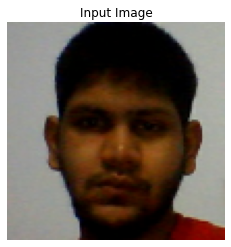

In [12]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret_val, frame = cap.read()
    
    # Cut down frame to (250 x 250)px
    frame = frame[120:120+250, 120:120+250, :]
    
    cv2.imshow("Verification Window", frame)
    
    # If 'v' is pressed, verify the face 
    if cv2.waitKey(1) & 0XFF == ord('v'):
        # Save the image
        cv2.imwrite(os.path.join("Application_data", "Input_image", "input_img.jpg"), frame)
        # Verify the image
        verify(siamese_model, 0.5, 0.5)
    
    # If 'q' is pressed, close the 'Verification Window'
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()